# Численные методы решения дифференциальных уравнений с частными производными.

In [1]:
import math

import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np

Вспомогательные константы и функции

In [2]:
! make solver

g++ -g -O2 -pedantic -std=c++17 -Wall -Wextra -Werror main.cpp -o solver


In [3]:
def write_arr(file, arr):
    file.write(" ".join(str(elem) for elem in arr) + "\n")


def write_tensor3(file, t):
    nz, nx, ny = t.shape
    for id_z in range(nz):
        for id_y in range(ny):
            ln = ""
            for id_x in range(nx):
                s = str(t[id_z][id_x][id_y])
                if id_x:
                    ln += " "
                ln += s
            file.write(ln + "\n")

### Ввод данных

Испольуземый численный метод

* $\psi = 1$ - метод переменных направлений
* $\psi = 2$ - метод дробных шагов

In [4]:
psi = 1

Ограничения по $x$, $y$ и $t$, параметр сетки.

$x \in [0, l_x]$, $y \in [0, l_y]$, $t \in [0, T]$

In [5]:
lx = np.pi / 2
ly = np.pi
T = 2

nx = 50
ny = 50
K = 50

Вариант

In [6]:
a = 1
b = 1
mu = 2

Коэффициенты уравнения

In [7]:
ax = a
ay = b
bx = 0
by = 0
c = 0


def f(x, y, t):
    return np.sin(x) * np.sin(y) * (mu * np.cos(mu * t) + (a + b) * np.sin(mu * t))

Коэффициенты в граничных условиях

In [8]:
alpha_0_y = 0
beta_0_y = 1

alpha_lx_y = 0
beta_lx_y = 1

alpha_x_0 = 0
beta_x_0 = 1

alpha_x_ly = 1
beta_x_ly = 0

Граничные условия

In [9]:
def gamma_0_y(y, t):
    return 0


def gamma_lx_y(y, t):
    return np.sin(y) * np.sin(mu * t)


def gamma_x_0(x, t):
    return 0


def gamma_x_ly(x, t):
    return -np.sin(x) * np.sin(mu * t)


def u0(x, y):
    return 0

Точное решение

In [10]:
def true_u(x, y, t):
    return np.sin(x) * np.sin(y) * np.sin(mu * t)

### Препроцессинг

Вычисление шагов $h$ и $\tau$

In [11]:
hx = lx / (nx - 1)
hy = ly / (ny - 1)
tau = T / (K - 1)

Генерация узлов сетки

In [12]:
t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * hx for i in range(nx - 1)]
x.append(lx)
x = np.array(x)

y = [i * hy for i in range(ny - 1)]
y.append(ly)
y = np.array(y)

Генерация начальных условий для решателя

In [13]:
f_ijk = np.ndarray((K, nx, ny))
for i in range(nx):
    for j in range(ny):
        for k in range(K):
            f_ijk[k][i][j] = f(x[i], y[j], t[k])

grid_u0 = np.ndarray((1, nx, ny))
for i in range(nx):
    for j in range(ny):
        grid_u0[0][i][j] = u0(x[i], y[j])

grid_0_y = np.ndarray((K, 1, ny))
grid_lx_y = np.ndarray((K, 1, ny))
for k in range(K):
    for j in range(ny):
        grid_0_y[k][0][j] = gamma_0_y(y[j], t[k])
        grid_lx_y[k][0][j] = gamma_lx_y(y[j], t[k])

grid_x_0 = np.ndarray((K, nx, 1))
grid_x_ly = np.ndarray((K, nx, 1))
for k in range(K):
    for i in range(nx):
        grid_x_0[k][i][0] = gamma_x_0(x[i], t[k])
        grid_x_ly[k][i][0] = gamma_x_ly(x[i], t[k])

with open("in.txt", "w") as file_in:
    write_arr(file_in, [nx, ny, K, psi])
    write_arr(file_in, [lx, ly, T, hx, hy, tau])
    write_arr(file_in, [ax, ay, bx, by, c])
    write_tensor3(file_in, f_ijk)
    write_tensor3(file_in, grid_u0)

    write_arr(
        file_in,
        [
            alpha_0_y,
            alpha_x_0,
            beta_0_y,
            beta_x_0,
            alpha_lx_y,
            alpha_x_ly,
            beta_lx_y,
            beta_x_ly,
        ],
    )
    write_tensor3(file_in, grid_0_y)
    write_tensor3(file_in, grid_x_0)
    write_tensor3(file_in, grid_lx_y)
    write_tensor3(file_in, grid_x_ly)

### Решение

In [14]:
! ./solver < in.txt > out.txt

### Постпроцессинг

In [15]:
data = np.ndarray((K, nx, ny))

with open("out.txt", "r") as file_out:
    j = 0
    k = 0
    for line in file_out:
        nums = [float(elem) for elem in line.split()]
        if not nums:
            continue
        for i, elem in enumerate(nums):
            data[k][i][j] = elem
        j += 1
        if j == ny:
            j = 0
            k += 1

In [16]:
true_data = np.ndarray((K, nx, ny))

for i in range(nx):
    for j in range(ny):
        for k in range(K):
            true_data[k][i][j] = true_u(x[i], y[j], t[k])

### Визуализация

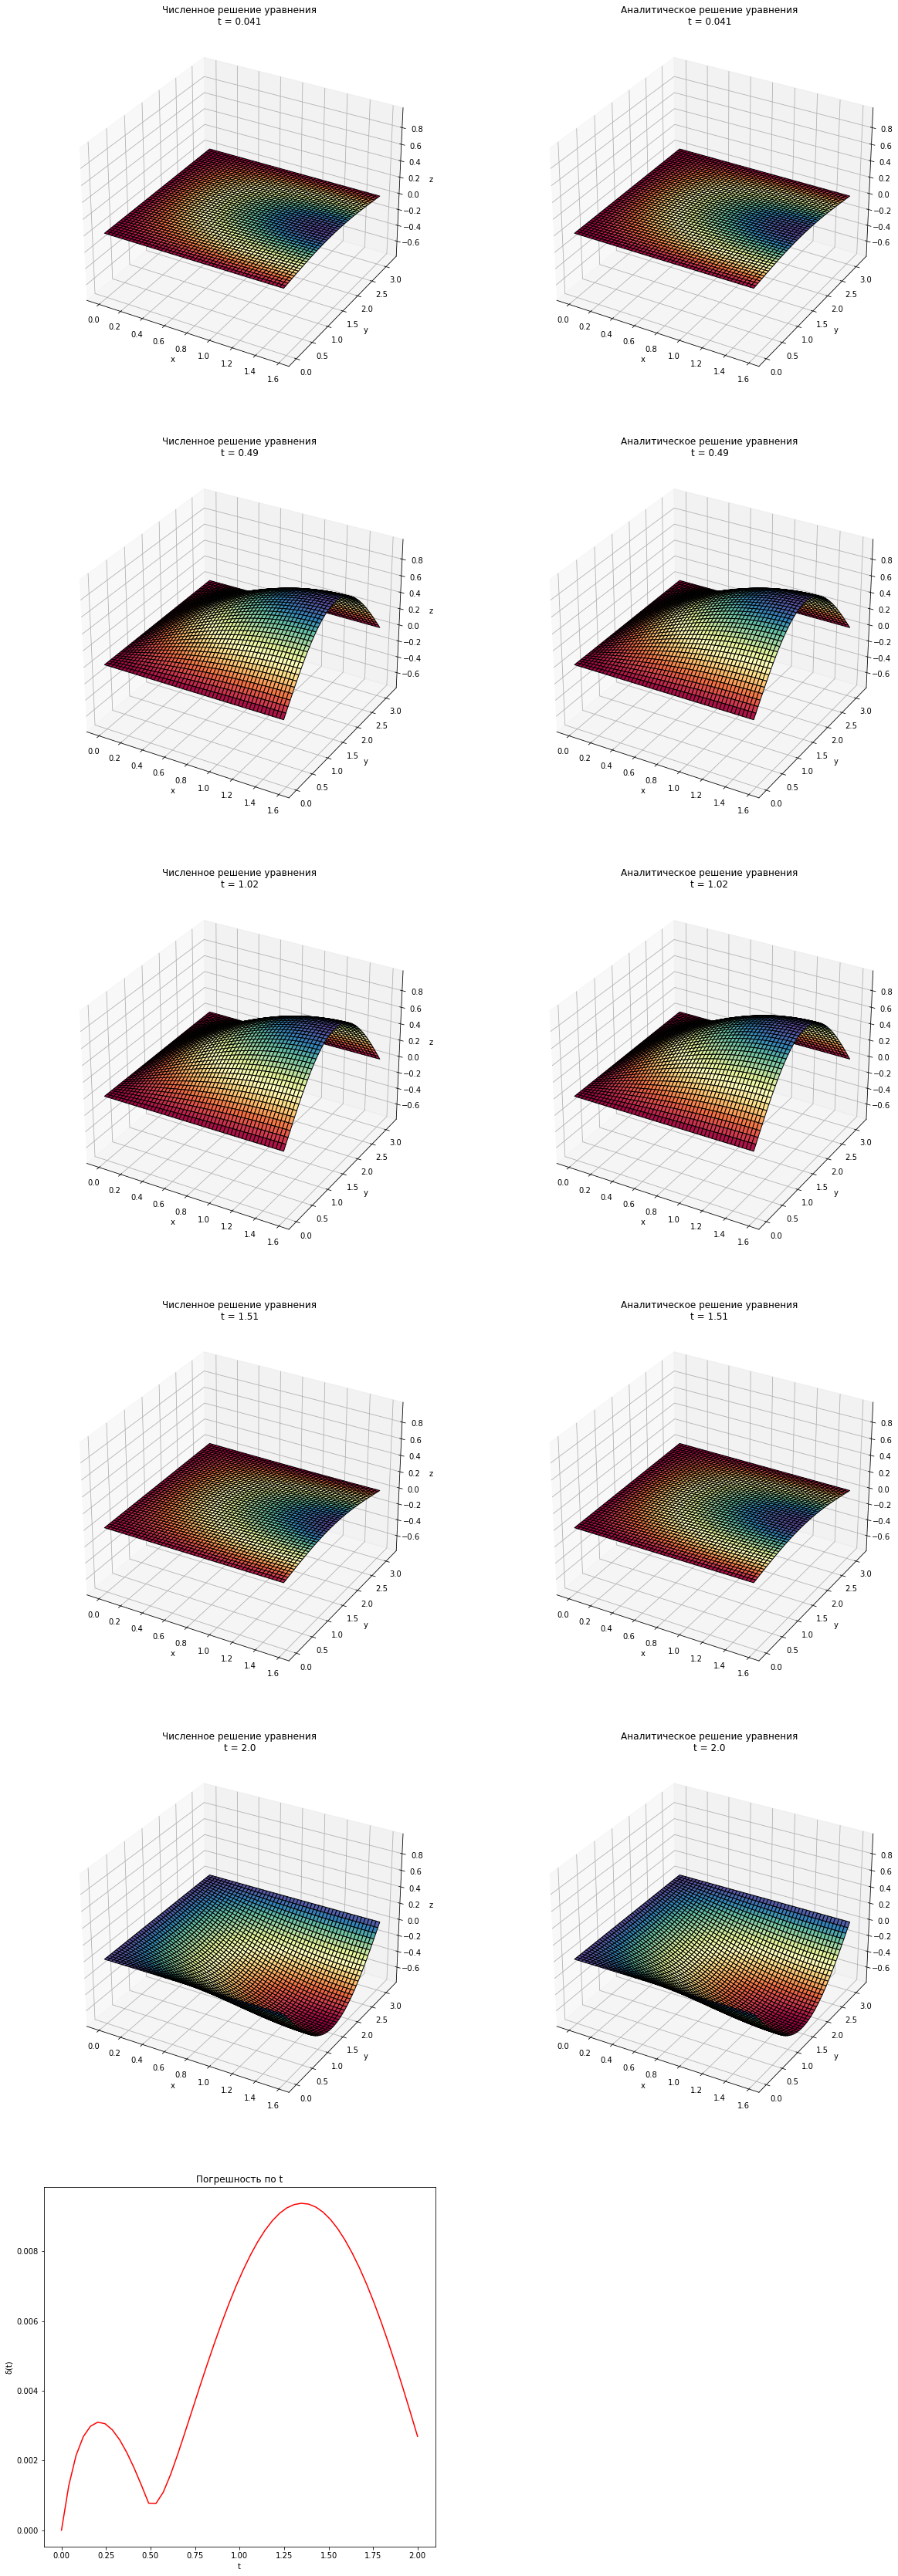

In [17]:
MIN_Z = min(np.min(true_data), np.min(data))
MAX_Z = max(np.max(true_data), np.max(data))
LAYERS = 5
PLOT_SZ = 10
DIGITS = 3


def subplot3d(ind, figure, _x, _y, _z, title):
    axes = figure.add_subplot(LAYERS + 1, 2, ind + 1, projection="3d")
    surface = axes.plot_surface(
        _x,
        _y,
        _z,
        edgecolors=["black"],
        linewidth=1,
        cmap=matplotlib.cm.Spectral,
        shade=True,
        antialiased=True,
    )
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.set_zlabel("z")
    axes.set_zlim(MIN_Z, MAX_Z)
    axes.set_title(title)


figure = plt.figure(figsize=(2 * PLOT_SZ, (LAYERS + 1) * PLOT_SZ))
x_plt, y_plt = np.meshgrid(y, x)

step = K / (LAYERS - 1)
ids = [int(step * i) for i in range(LAYERS - 1)]
ids[0] += 1
ids.append(K - 1)

for i, elem in enumerate(ids):
    subplot3d(
        2 * i,
        figure,
        y_plt,
        x_plt,
        data[elem],
        "Численное решение уравнения\nt = " + str(round(t[elem], DIGITS)),
    )
    subplot3d(
        (2 * i) ^ 1,
        figure,
        y_plt,
        x_plt,
        true_data[elem],
        "Аналитическое решение уравнения\nt = " + str(round(t[elem], DIGITS)),
    )

delta = np.abs(data - true_data)
axes = figure.add_subplot(LAYERS + 1, 2, LAYERS * 2 + 1)
axes.plot(t, np.max(delta, axis=(1, 2)), color="red")
plt.title("Погрешность по t")
plt.xlabel("t")
plt.ylabel("δ(t)")

plt.show()